This first model is the LSTM model without gradient accumulation

Here I am manually testing for an optimal batch size.

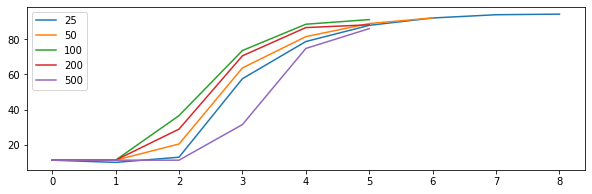

In [51]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import time

accuracyArrNoGradAccu = []
train_losses_no_grad_accu = []


# plt.figure(figsize=(10,5))
# plt.title("Training and Validation Loss")
# plt.plot(val_losses,label="val")
# plt.plot(train_losses,label="train")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# writer = SummaryWriter()

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
batch_size_list = [25, 50, 100, 200, 500]#, 200]#, 512, 1024]

batch_and_n_iters = {
    25:7000,
    50:4500,
    100:3000,
    200:3000,
    500:3000
    }
accuracies_map = {}
loss_map = {}
with open('nogradaccum_mkIII_iters_scaled_back_in.txt', 'w') as f:
    with redirect_stdout(f):
        for batch_size, n_iters in batch_and_n_iters.items():
            t0 = time.time()
            curr_acc_list = []
            curr_loss_list = []
            print(f'####################################################################################################################################################################################\nbatch_size: {batch_size}')
            '''
            STEP 1: LOADING DATASET
            '''
            train_dataset = dsets.MNIST(root='./data', 
                                        train=True, 
                                        transform=transforms.ToTensor(),
                                        download=True)

            test_dataset = dsets.MNIST(root='./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

            '''
            STEP 2: MAKING DATASET ITERABLE
            '''
            # accumulation_steps = 5
            # batch_size = 20
            # n_iters = 3000
            # n_iters = 8000

            ## note the len of the train_dataset is 60000
            num_epochs = n_iters / (len(train_dataset) / batch_size)
            num_epochs = int(num_epochs)

            train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

            test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle=False)

            '''
            STEP 3: CREATE MODEL CLASS
            '''

            class LSTMModel(nn.Module):
                def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
                    super(LSTMModel, self).__init__()
                    # Hidden dimensions
                    self.hidden_dim = hidden_dim
                    
                    # Number of hidden layers
                    self.layer_dim = layer_dim
                    
                    # Building your LSTM
                    # batch_first=True causes input/output tensors to be of shape
                    # (batch_dim, seq_dim, feature_dim)
                    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
                    
                    # Readout layer
                    self.fc = nn.Linear(hidden_dim, output_dim)
                
                def forward(self, x):
                    # Initialize hidden state with zeros
                    #######################
                    #  USE GPU FOR MODEL  #
                    #######################
                    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                    
                    # Initialize cell state
                    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                    
                    # One time step
                    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
                    
                    # Index hidden state of last time step
                    # out.size() --> 100, 28, 100
                    # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
                    out = self.fc(out[:, -1, :]) 
                    # out.size() --> 100, 10
                    return out

            '''
            STEP 4: INSTANTIATE MODEL CLASS
            '''
            input_dim = 28
            hidden_dim = 100
            layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
            output_dim = 10

            model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

            #######################
            #  USE GPU FOR MODEL  #
            #######################
                
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model.to(device)
                
            '''
            STEP 5: INSTANTIATE LOSS CLASS
            '''
            criterion = nn.CrossEntropyLoss()

            '''
            STEP 6: INSTANTIATE OPTIMIZER CLASS
            '''
            learning_rate = 0.1
            # learning_rate = 0.5

            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

            '''
            STEP 7: TRAIN THE MODEL
            '''

            # Number of steps to unroll
            seq_dim = 28  


            iter = 0
            for epoch in range(num_epochs):
                for i, (images, labels) in enumerate(train_loader):
                    # Load images as Variable
                    #######################
                    #  USE GPU FOR MODEL  #
                    #######################
                    images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
                    labels = labels.to(device)
                        
                    # # Clear gradients w.r.t. parameters
                    optimizer.zero_grad()
                    
                    # Forward pass to get output/logits
                    # outputs.size() --> 100, 10
                    outputs = model(images)
                    
                    # Calculate Loss: softmax --> cross entropy loss
                    loss = criterion(outputs, labels) #/ accumulation_steps
                    
                    # Getting gradients w.r.t. parameters
                    loss.backward()
                    
                    # Updating parameters
                    optimizer.step()
                    
                    iter += 1
                        
                    if iter % 500 == 0:
                        # Calculate Accuracy         
                        correct = 0
                        total = 0
                        # Iterate through test dataset
                        for images, labels in test_loader:
                            #######################
                            #  USE GPU FOR MODEL  #
                            #######################
                            images = images.view(-1, seq_dim, input_dim).to(device)
                            labels = labels.to(device)
                            
                            # Forward pass only to get logits/output
                            outputs = model(images)
                            
                            # Get predictions from the maximum value
                            _, predicted = torch.max(outputs.data, 1)
                            
                            # Total number of labels
                            total += labels.size(0)
                            
                            # Total correct predictions
                            #######################
                            #  USE GPU FOR MODEL  #
                            #######################
                            if torch.cuda.is_available():
                                correct += (predicted.cpu() == labels.cpu()).sum()
                            else:
                                correct += (predicted == labels).sum()

                        accuracy = 100 * correct / total

                        train_losses_no_grad_accu.append(loss.item())
                        accuracyArrNoGradAccu.append(accuracy)

                        curr_acc_list.append(accuracy)
                        curr_loss_list.append(loss.item())

                        # Print Loss
                        print('Iteration: {}. Loss: {}. Accuracy: {}. Epoch: {}. Time in seconds: {}.'.format(iter, loss.item(), accuracy, epoch, time.time() - t0))
                        print(torch.cuda.memory_summary(abbreviated=False))
                        # accuracies_map[batch_size] = accuracyArrNoGradAccu
                        accuracies_map[batch_size] = curr_acc_list
                        loss_map[batch_size] = curr_loss_list 

plt.figure(figsize=(10, 3))
for k, v in accuracies_map.items():
    plt.plot(v, label=k)
plt.legend()  

Text(0, 0.5, 'Accuracy')

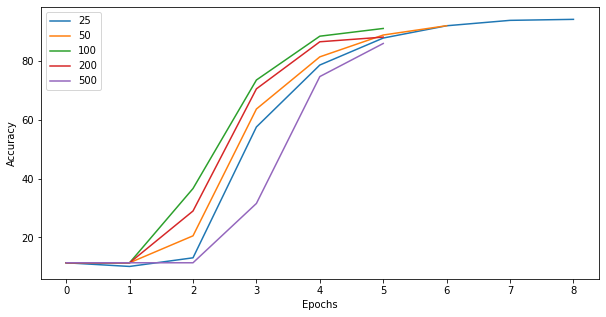

In [52]:
plt.figure(figsize=(10, 5))
for k, v in accuracies_map.items():
    plt.plot(v, label=k)
plt.legend()  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
	fig, ax1 = plt.subplots()

	color = 'tab:red'
	ax1.set_xlabel('Iterations')
	ax1.set_ylabel('Accuracy', color=color)
	ax1.plot(accuracyArr, color=color)
	ax1.tick_params(axis='y', labelcolor=color)

	ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

	color = 'tab:blue'
	ax2.set_ylabel('Loss %', color=color)  # we already handled the x-label with ax1
	ax2.plot(train_losses, color=color)
	ax2.tick_params(axis='y', labelcolor=color)

	fig.tight_layout()  # otherwise the right y-label is slightly clipped
	plt.show()

In [40]:
for k, v in accuracies_map.items():
    print(f'Batch size: {k}')
    for accu in v:
        # print(accu[accu.find("(")+1:accu.find(")")])
        print(f'Accuracy: {accu.item()}')
    print()

Batch size: 25
Accuracy: 11.350000381469727
Accuracy: 12.449999809265137
Accuracy: 26.469999313354492
Accuracy: 56.619998931884766

Batch size: 50
Accuracy: 11.350000381469727
Accuracy: 13.720000267028809
Accuracy: 46.83000183105469
Accuracy: 72.7699966430664

Batch size: 100
Accuracy: 11.350000381469727
Accuracy: 11.350000381469727
Accuracy: 24.290000915527344
Accuracy: 67.93000030517578
Accuracy: 79.44000244140625
Accuracy: 92.5199966430664

Batch size: 200
Accuracy: 11.350000381469727
Accuracy: 11.5
Accuracy: 45.0
Accuracy: 74.02999877929688
Accuracy: 88.91999816894531
Accuracy: 93.73999786376953

Batch size: 500
Accuracy: 11.350000381469727
Accuracy: 11.350000381469727
Accuracy: 25.81999969482422
Accuracy: 68.93000030517578
Accuracy: 80.76000213623047
Accuracy: 93.41999816894531



This will be individual batch size

In [54]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

accuracyArrNoGradAccuIndivual = []
train_losses_no_grad_accu_individual = []
total_allocated_memory_individual = []
total_allocated_max_memory_individual = []

# plt.figure(figsize=(10,5))
# plt.title("Training and Validation Loss")
# plt.plot(val_losses,label="val")
# plt.plot(train_losses,label="train")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# writer = SummaryWriter()

# torch.cuda.set_per_process_memory_fraction(0.5, 0)

with open('indvd_no_grad_accum_25_7k_mkII.txt', 'w') as f:
    with redirect_stdout(f):
        '''
        STEP 1: LOADING DATASET
        '''
        train_dataset = dsets.MNIST(root='./data', 
                                    train=True, 
                                    transform=transforms.ToTensor(),
                                    download=True)

        test_dataset = dsets.MNIST(root='./data', 
                                train=False, 
                                transform=transforms.ToTensor())

        '''
        STEP 2: MAKING DATASET ITERABLE
        '''
        # accumulation_steps = 5
        batch_size = 25
        n_iters = 7000
        # n_iters = 8000

        ## note the len of the train_dataset is 60000
        num_epochs = n_iters / (len(train_dataset) / batch_size)
        num_epochs = int(num_epochs)
        
        print(f'batch_size: {batch_size}\nnum_iters: {n_iters}\nnum_epochs: {num_epochs}\ngrad_accum: no')
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

        '''
        STEP 3: CREATE MODEL CLASS
        '''

        class LSTMModel(nn.Module):
            def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
                super(LSTMModel, self).__init__()
                # Hidden dimensions
                self.hidden_dim = hidden_dim
                
                # Number of hidden layers
                self.layer_dim = layer_dim
                
                # Building your LSTM
                # batch_first=True causes input/output tensors to be of shape
                # (batch_dim, seq_dim, feature_dim)
                self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
                
                # Readout layer
                self.fc = nn.Linear(hidden_dim, output_dim)
            
            def forward(self, x):
                # Initialize hidden state with zeros
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                
                # Initialize cell state
                c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                
                # One time step
                out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
                
                # Index hidden state of last time step
                # out.size() --> 100, 28, 100
                # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
                out = self.fc(out[:, -1, :]) 
                # out.size() --> 100, 10
                return out

        '''
        STEP 4: INSTANTIATE MODEL CLASS
        '''
        input_dim = 28
        hidden_dim = 100
        layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
        output_dim = 10

        model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

        #######################
        #  USE GPU FOR MODEL  #
        #######################
            
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
            
        '''
        STEP 5: INSTANTIATE LOSS CLASS
        '''
        criterion = nn.CrossEntropyLoss()

        '''
        STEP 6: INSTANTIATE OPTIMIZER CLASS
        '''
        learning_rate = 0.1
        # learning_rate = 0.5

        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

        '''
        STEP 7: TRAIN THE MODEL
        '''

        # Number of steps to unroll
        seq_dim = 28  


        iter = 0
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                # Load images as Variable
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
                labels = labels.to(device)
                    
                # # Clear gradients w.r.t. parameters
                optimizer.zero_grad()
                
                # Forward pass to get output/logits
                # outputs.size() --> 100, 10
                outputs = model(images)
                
                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels) #/ accumulation_steps
                
                # Getting gradients w.r.t. parameters
                loss.backward()
                
                # Updating parameters
                optimizer.step()
                
                iter += 1
                    
                if iter % 500 == 0:
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for images, labels in test_loader:
                        #######################
                        #  USE GPU FOR MODEL  #
                        #######################
                        images = images.view(-1, seq_dim, input_dim).to(device)
                        labels = labels.to(device)
                        
                        # Forward pass only to get logits/output
                        outputs = model(images)
                        
                        # Get predictions from the maximum value
                        _, predicted = torch.max(outputs.data, 1)
                        
                        # Total number of labels
                        total += labels.size(0)
                        
                        # Total correct predictions
                        #######################
                        #  USE GPU FOR MODEL  #
                        #######################
                        if torch.cuda.is_available():
                            correct += (predicted.cpu() == labels.cpu()).sum()
                        else:
                            correct += (predicted == labels).sum()

                    accuracy = 100 * correct / total

                    train_losses_no_grad_accu_individual.append(loss.item())
                    total_allocated_memory_individual.append(torch.cuda.memory_allocated())
                    total_allocated_max_memory_individual.append(torch.cuda.max_memory_allocated())
                    accuracyArrNoGradAccuIndivual.append(accuracy)

                    # Print Loss
                    print('Iteration: {}. Loss: {}. Accuracy: {}. \nEpoch: {}. Time in seconds: {}.\nMemory Allocated: {}.Max Memory Allocated: {}'.format(iter, loss.item(), accuracy, epoch, time.time() - t0, torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated()))
                    print(torch.cuda.memory_summary(abbreviated=False))

Plotting accuracy vs loss

<Figure size 720x720 with 0 Axes>

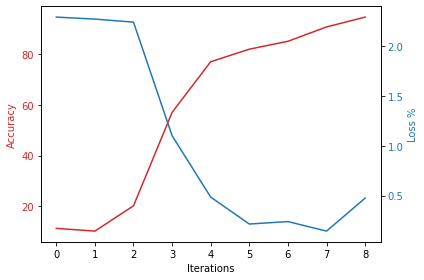

In [60]:
# def graph_results_no_grad_accum(train_losses_no_grad_accu_individual, accuracyArrNoGradAccuIndivual):

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(accuracyArrNoGradAccuIndivual, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss %', color=color)  # we already handled the x-label with ax1
ax2.plot(train_losses_no_grad_accu_individual, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<Figure size 720x720 with 0 Axes>

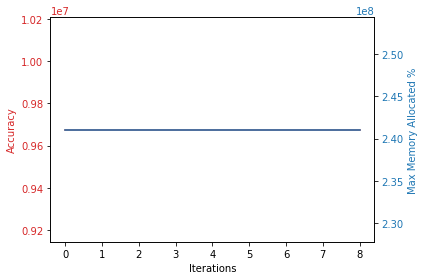

In [61]:
plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(total_allocated_memory_individual, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Max Memory Allocated %', color=color)  # we already handled the x-label with ax1
ax2.plot(total_allocated_max_memory_individual, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
accuracies_map = {}
batch_size = 20
n_iters = 3000
withoutGradAccum(batch_size, n_iters, accuracies_map)
graph_results_no_grad_accum(train_losses_no_grad_accu, accuracyArrNoGradAccu)


## This first model is the LSTM model with gradient accumulation

Optimizing batch size

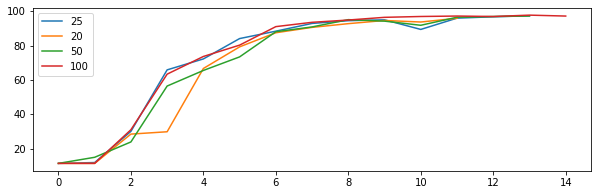

In [66]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import time
import numpy as np

accuracyArrGradBatch = []
train_losses_grad_batch = []
total_allocated_memory_batch_grad_accum = []
total_allocated_max_memory_batch_grad_accum = []

# writer = SummaryWriter()

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
# theo_batch_size_list = [25, 50, 100, 200, 500]#, 200]#, 512, 1024]
batch_and_accum_step = {
    5:5,
    25:2,
    20:5,
    50:4,
    100:5
    }
accuracies_dict_grad_batch = {}
with open('gradaccum_mkII_batch_8k_iter.txt', 'w') as f:
    with redirect_stdout(f):
        for batch_size, accum_steps in batch_and_accum_step.items():
            t0 = time.time()
            curr_acc_list = []
            print('#################################################################')
            print(f'\nbatch_size: {batch_size}. accum_step: {accum_steps}. theo_batch_size: {batch_size*accum_steps}')
            '''
            STEP 1: LOADING DATASET
            '''
            train_dataset = dsets.MNIST(root='./data', 
                                        train=True, 
                                        transform=transforms.ToTensor(),
                                        download=True)

            test_dataset = dsets.MNIST(root='./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

            '''
            STEP 2: MAKING DATASET ITERABLE
            '''
            # accumulation_steps = 5
            # batch_size = 20
            n_iters = 8000
            # n_iters = 8000

            ## note the len of the train_dataset is 60000
            num_epochs = n_iters / (len(train_dataset) / batch_size)
            num_epochs = int(num_epochs)

            train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

            test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle=False)

            '''
            STEP 3: CREATE MODEL CLASS
            '''

            class LSTMModel(nn.Module):
                def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
                    super(LSTMModel, self).__init__()
                    # Hidden dimensions
                    self.hidden_dim = hidden_dim
                    
                    # Number of hidden layers
                    self.layer_dim = layer_dim
                    
                    # Building your LSTM
                    # batch_first=True causes input/output tensors to be of shape
                    # (batch_dim, seq_dim, feature_dim)
                    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
                    
                    # Readout layer
                    self.fc = nn.Linear(hidden_dim, output_dim)
                
                def forward(self, x):
                    # Initialize hidden state with zeros
                    #######################
                    #  USE GPU FOR MODEL  #
                    #######################
                    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                    
                    # Initialize cell state
                    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                    
                    # One time step
                    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
                    
                    # Index hidden state of last time step
                    # out.size() --> 100, 28, 100
                    # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
                    out = self.fc(out[:, -1, :]) 
                    # out.size() --> 100, 10
                    return out

            '''
            STEP 4: INSTANTIATE MODEL CLASS
            '''
            input_dim = 28
            hidden_dim = 100
            layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
            output_dim = 10

            model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

            #######################
            #  USE GPU FOR MODEL  #
            #######################
                
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model.to(device)
                
            '''
            STEP 5: INSTANTIATE LOSS CLASS
            '''
            criterion = nn.CrossEntropyLoss()

            '''
            STEP 6: INSTANTIATE OPTIMIZER CLASS
            '''
            learning_rate = 0.1
            # learning_rate = 0.5

            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

            '''
            STEP 7: TRAIN THE MODEL
            '''

            # Number of steps to unroll
            seq_dim = 28  


            iter = 0
            for epoch in range(num_epochs):
                for i, (images, labels) in enumerate(train_loader):
                    # Load images as Variable
                    #######################
                    #  USE GPU FOR MODEL  #
                    #######################
                    images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
                    labels = labels.to(device)
                        
                    # # Clear gradients w.r.t. parameters
                    # optimizer.zero_grad()
                    
                    # Forward pass to get output/logits
                    # outputs.size() --> 100, 10
                    outputs = model(images)
                    
                    # Calculate Loss: softmax --> cross entropy loss
                    loss = criterion(outputs, labels) #/ accumulation_steps
                    
                    # Getting gradients w.r.t. parameters
                    loss.backward()
                    
                    if ((i + 1) % accum_steps == 0) or (i + 1 == len(train_dataset)):
                    # if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
                        optimizer.step()
                        optimizer.zero_grad()

                    # Updating parameters
                    # optimizer.step()
                    
                    iter += 1
                        
                    if iter % 500 == 0:
                        # Calculate Accuracy         
                        correct = 0
                        total = 0
                        # Iterate through test dataset
                        for images, labels in test_loader:
                            #######################
                            #  USE GPU FOR MODEL  #
                            #######################
                            images = images.view(-1, seq_dim, input_dim).to(device)
                            labels = labels.to(device)
                            
                            # Forward pass only to get logits/output
                            outputs = model(images)
                            
                            # Get predictions from the maximum value
                            _, predicted = torch.max(outputs.data, 1)
                            
                            # Total number of labels
                            total += labels.size(0)
                            
                            # Total correct predictions
                            #######################
                            #  USE GPU FOR MODEL  #
                            #######################
                            if torch.cuda.is_available():
                                correct += (predicted.cpu() == labels.cpu()).sum()
                            else:
                                correct += (predicted == labels).sum()

                        accuracy = 100 * correct / total

                        train_losses_grad_batch.append(loss.item())
                        accuracyArrGradBatch.append(accuracy)
                        curr_acc_list.append(accuracy)
                        total_allocated_memory_batch_grad_accum.append(torch.cuda.memory_allocated())
                        total_allocated_max_memory_batch_grad_accum.append(torch.cuda.max_memory_allocated())

                        # Print Loss
                        print('Iteration: {}. Loss: {}. Accuracy: {}. \nEpoch: {}. Time in seconds: {}.'.format(iter, loss.item(), accuracy, epoch, time.time() - t0))
                        print(torch.cuda.memory_summary(abbreviated=False))
                        accuracies_dict_grad_batch[batch_size] = curr_acc_list

plt.figure(figsize=(10, 3))
for k, v in accuracies_dict_grad_batch.items():
    plt.plot(v, label=k)
plt.legend()  

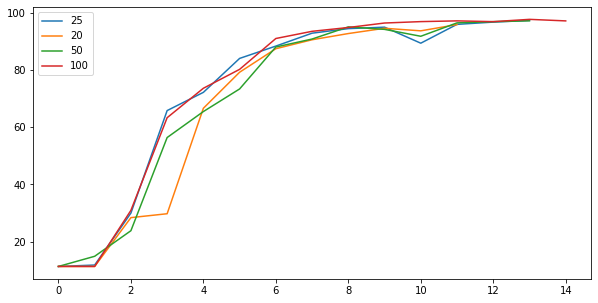

In [67]:
plt.figure(figsize=(10, 5))
for k, v in accuracies_dict_grad_batch.items():
    plt.plot(v, label=k)
plt.legend()  

The following is a single implementation

In [58]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

accuracyArrGradAccuIndivual = []
train_losses_grad_accu_individual = []
total_allocated_memory_individual_grad_accum = []
total_allocated_max_memory_individual_grad_accum = []

# plt.figure(figsize=(10,5))
# plt.title("Training and Validation Loss")
# plt.plot(val_losses,label="val")
# plt.plot(train_losses,label="train")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# writer = SummaryWriter()

# torch.cuda.set_per_process_memory_fraction(0.5, 0)

with open('indvd_25_7k.txt', 'w') as f:
    with redirect_stdout(f):
        '''
        STEP 1: LOADING DATASET
        '''
        train_dataset = dsets.MNIST(root='./data', 
                                    train=True, 
                                    transform=transforms.ToTensor(),
                                    download=True)

        test_dataset = dsets.MNIST(root='./data', 
                                train=False, 
                                transform=transforms.ToTensor())

        '''
        STEP 2: MAKING DATASET ITERABLE
        '''
        accumulation_steps = 5
        batch_size = 5
        n_iters = 7000
        # n_iters = 8000

        theo_batch_size = 25
        ## note the len of the train_dataset is 60000
        num_epochs = n_iters / (len(train_dataset) / theo_batch_size)
        num_epochs = int(num_epochs)
        
        print(f'theo_batch_size: {theo_batch_size}\nbatch_size: {batch_size}\nnum_iters: {n_iters}\nnum_epochs: {num_epochs}\ngrad_accum: no')
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

        '''
        STEP 3: CREATE MODEL CLASS
        '''

        class LSTMModel(nn.Module):
            def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
                super(LSTMModel, self).__init__()
                # Hidden dimensions
                self.hidden_dim = hidden_dim
                
                # Number of hidden layers
                self.layer_dim = layer_dim
                
                # Building your LSTM
                # batch_first=True causes input/output tensors to be of shape
                # (batch_dim, seq_dim, feature_dim)
                self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
                
                # Readout layer
                self.fc = nn.Linear(hidden_dim, output_dim)
            
            def forward(self, x):
                # Initialize hidden state with zeros
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                
                # Initialize cell state
                c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
                
                # One time step
                out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
                
                # Index hidden state of last time step
                # out.size() --> 100, 28, 100
                # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
                out = self.fc(out[:, -1, :]) 
                # out.size() --> 100, 10
                return out

        '''
        STEP 4: INSTANTIATE MODEL CLASS
        '''
        input_dim = 28
        hidden_dim = 100
        layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
        output_dim = 10

        model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

        #######################
        #  USE GPU FOR MODEL  #
        #######################
            
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
            
        '''
        STEP 5: INSTANTIATE LOSS CLASS
        '''
        criterion = nn.CrossEntropyLoss()

        '''
        STEP 6: INSTANTIATE OPTIMIZER CLASS
        '''
        learning_rate = 0.1
        # learning_rate = 0.5

        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

        '''
        STEP 7: TRAIN THE MODEL
        '''

        # Number of steps to unroll
        seq_dim = 28  


        iter = 0
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                # Load images as Variable
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
                labels = labels.to(device)
                    
                # # Clear gradients w.r.t. parameters
                # optimizer.zero_grad()
                
                # Forward pass to get output/logits
                # outputs.size() --> 100, 10
                outputs = model(images)
                
                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels) #/ accumulation_steps
                
                # Getting gradients w.r.t. parameters
                loss.backward()
                
                if ((i + 1) % accum_steps == 0) or (i + 1 == len(train_dataset)):
                # if (i+1) % accumulation_steps == 0:             # Wait for several backward steps 
                    # Updating parameters
                    optimizer.step()
                    optimizer.zero_grad()
                
                iter += 1
                    
                if iter % 500 == 0:
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for images, labels in test_loader:
                        #######################
                        #  USE GPU FOR MODEL  #
                        #######################
                        images = images.view(-1, seq_dim, input_dim).to(device)
                        labels = labels.to(device)
                        
                        # Forward pass only to get logits/output
                        outputs = model(images)
                        
                        # Get predictions from the maximum value
                        _, predicted = torch.max(outputs.data, 1)
                        
                        # Total number of labels
                        total += labels.size(0)
                        
                        # Total correct predictions
                        #######################
                        #  USE GPU FOR MODEL  #
                        #######################
                        if torch.cuda.is_available():
                            correct += (predicted.cpu() == labels.cpu()).sum()
                        else:
                            correct += (predicted == labels).sum()

                    accuracy = 100 * correct / total

                    train_losses_grad_accu_individual.append(loss.item())
                    total_allocated_memory_individual_grad_accum.append(torch.cuda.memory_allocated())
                    total_allocated_max_memory_individual_grad_accum.append(torch.cuda.max_memory_allocated())
                    accuracyArrGradAccuIndivual.append(accuracy)

                    # Print Loss
                    print('Iteration: {}. Loss: {}. Accuracy: {}. \nEpoch: {}. Time in seconds: {}.\nMemory Allocated: {}.Max Memory Allocated: {}'.format(iter, loss.item(), accuracy, epoch, time.time() - t0, torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated()))
                    print(torch.cuda.memory_summary(abbreviated=False))

This next cell graphs the accuracy and loss

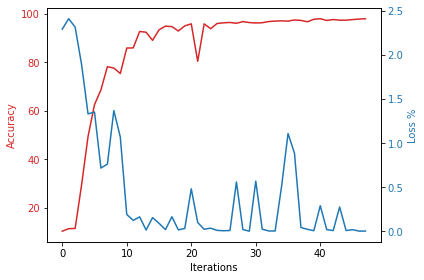

In [59]:

# def graph_results(train_losses, accuracyArr):
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(accuracyArrGradAccuIndivual, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss %', color=color)  # we already handled the x-label with ax1
ax2.plot(train_losses_grad_accu_individual, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Training the model on differing batch sizes

In [ ]:
batch_size_list = [32, 64, 128, 256, 512, 1024]

for batch_size in batch_size_list:
	withGradAccum(batch_size, accum_steps, n_iters)
	graph_results(train_losses, accuracyArr)

Iteration: 500. Loss: 2.2848763465881348. Accuracy: 11.350000381469727. Epoch: 0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    5727 KB |   11723 KB |  213298 MB |  213292 MB |
|       from large pool |    3719 KB |    9279 KB |  180688 MB |  180684 MB |
|       from small pool |    2008 KB |    3279 KB |   32609 MB |   32607 MB |
|---------------------------------------------------------------------------|
| Active memory         |    5727 KB |   11723 KB |  213298 M

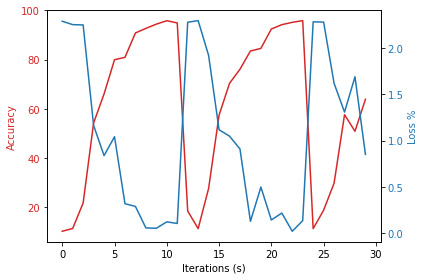

In [5]:
batch_size = 20
accum_steps = 5
n_iters = 6000
withGradAccum(batch_size, accum_steps, n_iters)
graph_results(train_losses, accuracyArr)